In [4]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, 
                                     MaxPooling2D, Concatenate, Flatten, Dense, Add, 
                                     AveragePooling2D, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import (confusion_matrix, roc_curve, auc, 
                             precision_score, recall_score, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import copy
from collections import deque
import math
import time

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

2025-10-31 12:25:45.253331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761913545.492014      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761913545.560970      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1.1 Global Configuration

In [5]:
DEFAULT_HYPERPARAMS = {
    "input_shape": (224, 224, 3),
    "num_classes": 3,
    "learning_rate": 0.0001,
    "epochs": 50,
    "batch_size": 16
}

BASE_PATH = "/kaggle/input/feature-selelcted-dataset"
CATEGORIES = ['normal', 'covid19', 'pneumonia']
IMAGE_SIZE = (DEFAULT_HYPERPARAMS['input_shape'][0], DEFAULT_HYPERPARAMS['input_shape'][1])
LABEL_MAPPING = {'covid19': 0, 'pneumonia': 1, 'normal': 2}
TARGET_NAMES = ['Covid-19', 'Pneumonia', 'Normal']

optimization_summary = {}

# 1. Data Loading and Preprocessing

In [6]:
def load_images(folder, categories, image_size):
    
    images, labels = [], []
    for category in categories:
        category_path = os.path.join(folder, category)
        if not os.path.isdir(category_path):
            print(f"Warning: Directory not found: {category_path}")
            continue
            
        for filename in os.listdir(category_path):
            img_path = os.path.join(category_path, filename)
            try:
                img = cv2.imread(img_path)  # Load in BGR
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
                    img = cv2.resize(img, image_size)
                    images.append(img)
                    labels.append(category)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                
    return np.array(images).astype('float32'), np.array(labels)

In [7]:
def encode_labels(labels, label_mapping, num_classes):
    int_labels = [label_mapping[label] for label in labels]
    return tf.keras.utils.to_categorical(int_labels, num_classes=num_classes).astype('float32')

train_images, train_labels_raw = load_images(
    os.path.join(BASE_PATH, 'train'), CATEGORIES, IMAGE_SIZE
)
test_images_full, test_labels_full_raw = load_images(
    os.path.join(BASE_PATH, 'test'), CATEGORIES, IMAGE_SIZE
)

val_images, test_images, val_labels_raw, test_labels_raw = train_test_split(
    test_images_full, test_labels_full_raw, 
    test_size=0.75, 
    stratify=test_labels_full_raw, 
    random_state=42
)

train_labels = encode_labels(train_labels_raw, LABEL_MAPPING, DEFAULT_HYPERPARAMS['num_classes'])
val_labels = encode_labels(val_labels_raw, LABEL_MAPPING, DEFAULT_HYPERPARAMS['num_classes'])
test_labels = encode_labels(test_labels_raw, LABEL_MAPPING, DEFAULT_HYPERPARAMS['num_classes'])

print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Test images shape: {test_images.shape}")

Train images shape: (1205, 224, 224, 3)
Validation images shape: (75, 224, 224, 3)
Test images shape: (227, 224, 224, 3)


# 2. Data Augmentation & Generators

## 2.1 Create Data Generators

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(
    x=train_images,
    y=train_labels,
    batch_size=DEFAULT_HYPERPARAMS['batch_size'],
    shuffle=True
)

validation_generator = val_test_datagen.flow(
    x=val_images,
    y=val_labels,
    batch_size=DEFAULT_HYPERPARAMS['batch_size'],
    shuffle=True
)

test_generator = val_test_datagen.flow(
    x=test_images,
    y=test_labels,
    batch_size=DEFAULT_HYPERPARAMS['batch_size'],
    shuffle=False
)

In [9]:
steps_per_epoch = math.ceil(len(train_images) / DEFAULT_HYPERPARAMS['batch_size'])
validation_steps = math.ceil(len(val_images) / DEFAULT_HYPERPARAMS['batch_size'])
test_steps = math.ceil(len(test_images) / DEFAULT_HYPERPARAMS['batch_size'])

# 3. Core Helper Functions (Model & Evaluation)

In [10]:
def build_vgg16_model(input_shape, num_classes, dropout_rate, learning_rate, dense_units):
    """
    Creates the VGG16 model with a custom hyperparameterized classification head.
    This function is used by all optimization algorithms.
    """
    inputs = tf.keras.Input(shape=input_shape, name='input_1')
    weights = 'imagenet'
    weights_path = os.path.expanduser('~/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    if os.path.exists(weights_path):
        weights = weights_path

    base_model = VGG16(weights=weights, include_top=False, input_tensor=inputs)
    base_model.trainable = False

    layer_name_mapping = {
        'block1_conv1': 'Glock1_conv1', 'block1_conv2': 'Glock1_conv2', 'block1_pool': 'Glock1_pool',
        'block2_conv1': 'Glock2_conv1', 'block2_conv2': 'Glock2_conv2', 'block2_pool': 'Glock2_coel',
        'block3_conv1': 'Glock3_conv1', 'block3_conv2': 'Glock3_conv2', 'block3_conv3': 'Glock3_conv3', 'block3_pool': 'Glock3_coel',
        'block4_conv1': 'Glock4_conv1', 'block4_conv2': 'Glock4_conv2', 'block4_conv3': 'Glock4_conv3', 'block4_pool': 'Glock4_coel',
        'block5_conv1': 'Glock5_conv1', 'block5_conv2': 'Glock5_conv2', 'block5_conv3': 'Glock5_conv3', 'block5_pool': 'Glock5_coel'
    }
    for layer in base_model.layers:
        if layer.name in layer_name_mapping:
            layer._name = layer_name_mapping[layer.name]
    
    x = base_model.output
    x = AveragePooling2D(pool_size=(4, 4), name='Avarage_poolZhg8')(x)
    x = Flatten(name='Atsitas')(x)
    
    x = Dense(dense_units, activation='relu', name='Aonte')(x)
    
    x = Dropout(dropout_rate, name='Argoat_dropout')(x)
    outputs = Dense(num_classes, activation='softmax', name='Gonsu_2_softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='nCOVnet_Optimized')

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [11]:
def plot_training_history(history, title="Model Training History"):
    """
    Plots accuracy and loss curves for a given Keras history object.
    Returns the max validation accuracy and min validation loss.
    """
    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    max_val_acc = max(history.history['val_accuracy'])
    min_val_loss = min(history.history['val_loss'])
    return max_val_acc, min_val_loss

In [12]:
def evaluate_model(model, test_generator, target_names, title="Model Evaluation"):

    print(f"\n--- {title} ---")
    
    # 0. Evaluate model for loss and accuracy
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # 1. Make predictions
    y_pred_probs = model.predict(test_generator, steps=test_steps)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # 2. Get true labels
    # We use test_generator.y which we know is not shuffled
    y_true = np.argmax(test_generator.y, axis=1)
    
    # 3. Print Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))

    # 4. Calculate Sensitivity and Specificity
    cm = confusion_matrix(y_true, y_pred)
    sensitivities, specificities = [], []
    for i in range(len(cm)):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    overall_sensitivity = np.mean(sensitivities)
    overall_specificity = np.mean(specificities)
    
    print(f"Overall Sensitivity (macro-averaged) = {overall_sensitivity:.4f}")
    print(f"Overall Specificity (macro-averaged) = {overall_specificity:.4f}")

    # 5. Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # 6. Plot ROC Curve (One vs Rest)
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = len(target_names)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_generator.y[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve ({target_names[i]}) (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {title}')
    plt.legend(loc='lower right')
    plt.show()
    
    return test_loss, test_accuracy, overall_sensitivity, overall_specificity

# 4. Optimization 1: Particle Swarm Optimization (PSO)

## 4.1 PSO Definitions

In [13]:
bounds = [
    (1e-5, 1e-3, 'log'),       # 0: lr
    (8, 32, 'int'),            # 1: batch
    (0.0, 0.6, 'linear'),      # 2: dropout
    (2, 10, 'int'),            # 3: epochs (Short run for PSO)
    (16, 256, 'int')           # 4: dense_units
]

In [14]:
class Particle:
    def __init__(self, bounds):
        self.pos=[]; self.vel=[]
        for lo,hi,t in bounds:
            if t=='log': val=10**np.random.uniform(np.log10(lo), np.log10(hi))
            elif t=='int': val=np.random.randint(lo, hi+1)
            else: val=np.random.uniform(lo,hi)
            self.pos.append(val); self.vel.append(0.0)
        self.best_pos=self.pos.copy(); self.best_score=-1e9

def enforce(idx, val):
    lo,hi,t = bounds[idx]
    if t=='int':
        v=int(round(val)); v=max(lo,min(hi,v)); return v
    if t=='log' or t=='linear':
        v=float(val); v=max(lo,min(hi,v)); return v
    return val

In [15]:
def eval_particle(particle, sample_train_imgs, sample_train_labels, sample_val_imgs, sample_val_labels):

    lr = particle.pos[0]
    batch = int(round(particle.pos[1]))
    dropout = particle.pos[2]
    epochs = int(round(particle.pos[3]))
    dense_units = int(round(particle.pos[4]))

    input_shape = sample_train_imgs.shape[1:]
    num_classes = sample_train_labels.shape[1]

    # Use the helper function to build the model
    m = build_vgg16_model(input_shape, num_classes, dropout, lr, dense_units)
    
    history = m.fit(
        sample_train_imgs, sample_train_labels, # Fit on raw arrays
        batch_size=batch,
        epochs=epochs,
        validation_data=(sample_val_imgs, sample_val_labels),
        verbose=0 
    )
    score = max(history.history['val_accuracy'])

    del m
    tf.keras.backend.clear_session()
    
    return score

## 4.2 PSO Execution

In [16]:
pso_start_time = time.time()

num_particles = 15
max_iter = 10
w, c1, c2 = 0.5, 1.0, 1.0

swarm = [Particle(bounds) for _ in range(num_particles)]
gbest_pos=None; gbest_score=-1e9

for it in range(max_iter):
    print(f'PSO iter {it+1}/{max_iter}')
    
    for i,p in enumerate(swarm):
        # We pass the in-memory NumPy arrays for this evaluation
        score = eval_particle(p, train_images, train_labels, val_images, val_labels) 
        
        print(f'  particle {i} -> val_acc {score:.4f}')
        print(f'  LR={p.pos[0]:.2e}, Batch={int(round(p.pos[1]))}, Dropout={p.pos[2]:.2f}, Epochs={int(round(p.pos[3]))}, Dense={int(round(p.pos[4]))}') 

        if score > p.best_score:
            p.best_score=score; p.best_pos=p.pos.copy()
            
        if score > gbest_score:
            gbest_score=score; gbest_pos=p.pos.copy()
            
    for p in swarm:
        for j in range(len(p.pos)):
            r1, r2 = np.random.rand(), np.random.rand()
            cognitive = c1 * r1 * (p.best_pos[j] - p.pos[j])
            social = c2 * r2 * (gbest_pos[j] - p.pos[j]) if gbest_pos is not None else 0
            p.vel[j] = w * p.vel[j] + cognitive + social
            p.pos[j] = enforce(j, p.pos[j] + p.vel[j])

pso_exec_time = time.time() - pso_start_time
print(f"--- PSO Optimization Finished in {pso_exec_time:.2f} seconds ---")
print('PSO best score:', gbest_score)
print('PSO best pos:', gbest_pos)

PSO iter 1/10


I0000 00:00:1761913574.889804      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761913574.890530      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1761913580.510740     100 service.cc:148] XLA service 0x7afd5c08e3a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761913580.511765     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761913580.511783     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761913580.887323     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761913589.988713     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  particle 0 -> val_acc 0.6400
  LR=5.61e-05, Batch=22, Dropout=0.44, Epochs=6, Dense=118
  particle 1 -> val_acc 0.7333
  LR=7.79e-05, Batch=30, Dropout=0.03, Epochs=9, Dense=132
  particle 2 -> val_acc 0.5600
  LR=1.59e-04, Batch=31, Dropout=0.39, Epochs=6, Dense=17
  particle 3 -> val_acc 0.8800
  LR=2.78e-04, Batch=13, Dropout=0.00, Epochs=6, Dense=176
  particle 4 -> val_acc 0.6667
  LR=4.06e-05, Batch=29, Dropout=0.00, Epochs=10, Dense=64
  particle 5 -> val_acc 0.7067
  LR=1.12e-04, Batch=17, Dropout=0.03, Epochs=4, Dense=123
  particle 6 -> val_acc 0.7467
  LR=1.07e-04, Batch=32, Dropout=0.03, Epochs=4, Dense=150
  particle 7 -> val_acc 0.7067
  LR=2.19e-05, Batch=14, Dropout=0.01, Epochs=10, Dense=75
  particle 8 -> val_acc 0.7067
  LR=1.34e-04, Batch=16, Dropout=0.01, Epochs=3, Dense=99
  particle 9 -> val_acc 0.7333
  LR=3.03e-05, Batch=14, Dropout=0.37, Epochs=9, Dense=190
  particle 10 -> val_acc 0.6800
  LR=2.22e-05, Batch=24, Dropout=0.16, Epochs=9, Dense=147
  particle 

## 4.3 Final PSO Model Training & Evaluation

In [17]:
if gbest_pos is not None:
    lr_pso = gbest_pos[0]
    dropout_pso = gbest_pos[2]
    epochs_pso = DEFAULT_HYPERPARAMS['epochs']
    dense_units_pso = int(round(gbest_pos[4]))
else:
    print("PSO failed, using default parameters.")
    lr_pso = DEFAULT_HYPERPARAMS['learning_rate']
    dropout_pso = 0.5
    epochs_pso = DEFAULT_HYPERPARAMS['epochs']
    dense_units_pso = 256

best_model_pso = build_vgg16_model(
    DEFAULT_HYPERPARAMS['input_shape'], 
    DEFAULT_HYPERPARAMS['num_classes'], 
    dropout_pso, 
    lr_pso, 
    dense_units_pso
)

print(f"Training VGG16 (PSO) model for {epochs_pso} epochs with optimal HPs:")
print(f"LR: {lr_pso:.6f}, Dropout: {dropout_pso:.4f}, Dense: {dense_units_pso}")
print(f"Using Generator Batch Size: {DEFAULT_HYPERPARAMS['batch_size']}")

Training VGG16 (PSO) model for 50 epochs with optimal HPs:
LR: 0.000458, Dropout: 0.1292, Dense: 185
Using Generator Batch Size: 16


## **Use the new generators for final training**

In [18]:
pso_train_start_time = time.time()
history_pso = best_model_pso.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs_pso,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1 
)
pso_train_time = time.time() - pso_train_start_time
print(f"--- PSO Final Training Finished in {pso_train_time:.2f} seconds ---")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.4488 - loss: 1.0216 - val_accuracy: 0.6933 - val_loss: 0.7285
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.6759 - loss: 0.7187 - val_accuracy: 0.6533 - val_loss: 0.6633
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.6416 - loss: 0.6469 - val_accuracy: 0.6933 - val_loss: 0.6068
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.7181 - loss: 0.5996 - val_accuracy: 0.6533 - val_loss: 0.5856
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.7032 - loss: 0.5831 - val_accuracy: 0.6667 - val_loss: 0.5928
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.7108 - loss: 0.5708 - val_accuracy: 0.6800 - val_loss: 0.5679
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.7315 - loss: 0.5347 - val_accuracy: 0.6800 - val_loss: 0.5678
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.7344 - loss: 0.5495 - val_accu

## 4.4 Evaluation (using helper functions)

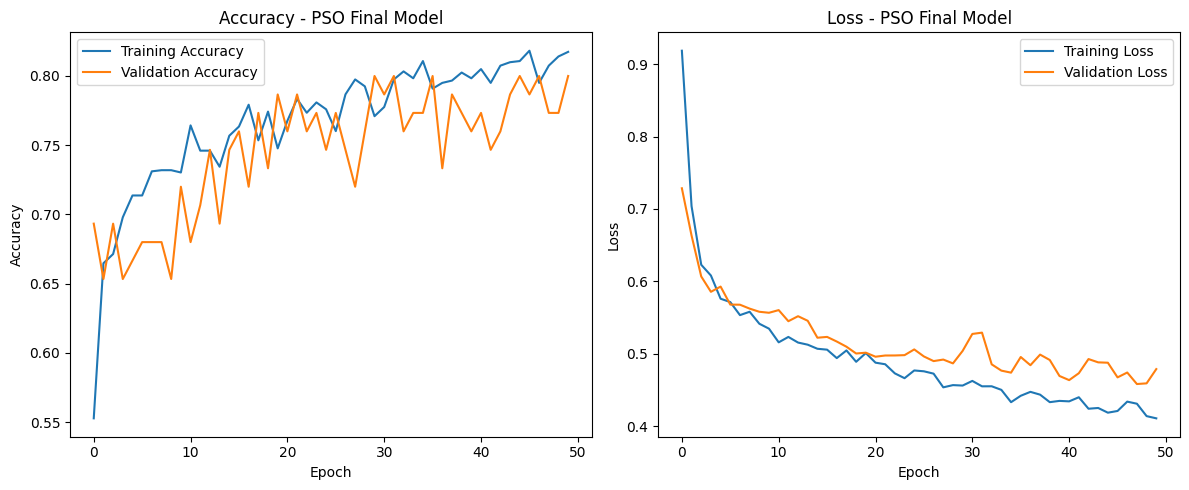


--- PSO Final Model ---
Test Loss: 0.4087, Test Accuracy: 0.8194
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step

Classification Report:
              precision    recall  f1-score   support

    Covid-19       0.79      0.71      0.75        76
   Pneumonia       0.70      0.85      0.77        75
      Normal       1.00      0.89      0.94        76

    accuracy                           0.82       227
   macro avg       0.83      0.82      0.82       227
weighted avg       0.83      0.82      0.82       227

Overall Sensitivity (macro-averaged) = 0.8195
Overall Specificity (macro-averaged) = 0.9099


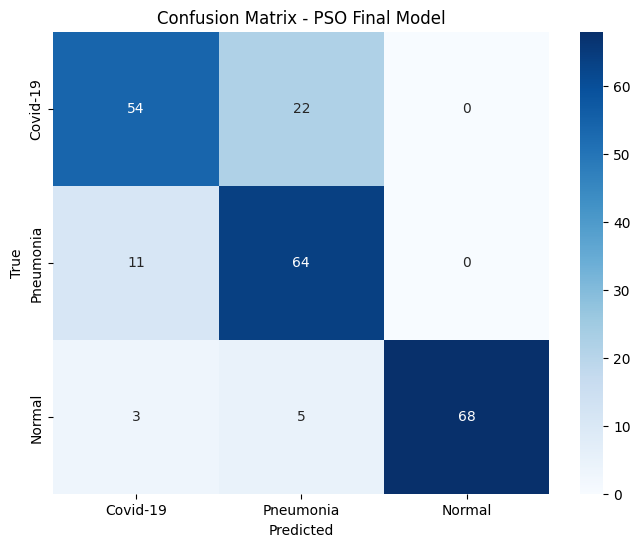

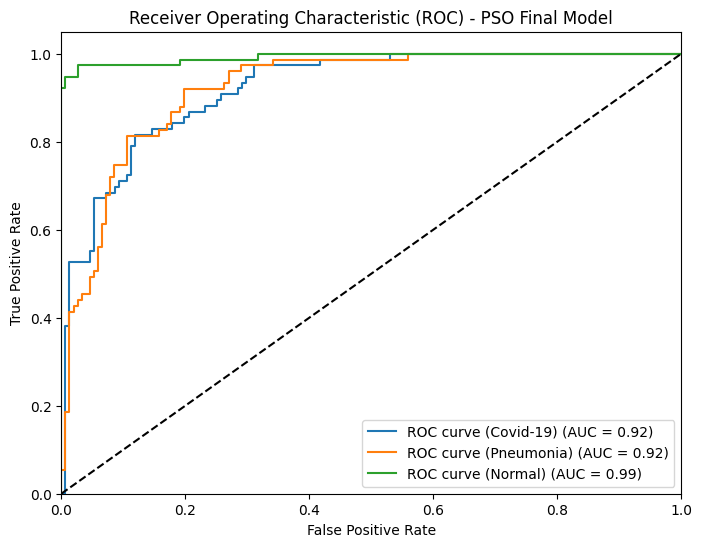

In [19]:
max_val_acc_pso, min_val_loss_pso = plot_training_history(history_pso, title="PSO Final Model")
test_loss_pso, test_acc_pso, sens_pso, spec_pso = evaluate_model(best_model_pso, test_generator, TARGET_NAMES, title="PSO Final Model")

## 4.5 Store results

In [ ]:
optimization_summary['PSO'] = {
    'Test Accuracy': test_acc_pso,
    'Test Loss': test_loss_pso,
    'Max Validation Accuracy': max_val_acc_pso,
    'Min Validation Loss': min_val_loss_pso,
    'Sensitivity': sens_pso,
    'Specificity': spec_pso,
    'Optimization Time (s)': pso_exec_time,
    'Final Training Time (s)': pso_train_time,
    'Total Time (s)': pso_exec_time + pso_train_time,
    'HPs': {'LR': lr_pso, 'Dropout': dropout_pso, 'Dense': dense_units_pso}
}

In [20]:
optimization_summary['PSO']

{'Test Accuracy': 0.8193832635879517,
 'Test Loss': 0.4086640775203705,
 'Max Validation Accuracy': 0.800000011920929,
 'Min Validation Loss': 0.4582538306713104,
 'Sensitivity': 0.8195321637426901,
 'Specificity': 0.9098843964215173,
 'Optimization Time (s)': 8654.724429130554,
 'Final Training Time (s)': 619.5028848648071,
 'Total Time (s)': 9274.227313995361,
 'HPs': {'LR': 0.0004575085234040853,
  'Dropout': 0.12922144901710003,
  'Dense': 185}}

# 5. Optimization 2: Ant Colony Optimization (ACO) for Feature Selection

## 5.1 Feature Extraction

In [25]:
def build_vgg16_feature_extractor(input_shape):
    weights_path = os.path.expanduser('~/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    inputs = Input(shape=input_shape)
    base_model = VGG16(
        weights=weights_path if os.path.exists(weights_path) else 'imagenet',
        include_top=False, 
        input_tensor=inputs
    )
    
    x = base_model.output
    x = AveragePooling2D(pool_size=(4, 4), name='avg_pool')(x)
    output_features = Flatten(name='flatten_features')(x)
    extractor = Model(inputs=inputs, outputs=output_features)
    return extractor

feature_extractor_model = build_vgg16_feature_extractor(DEFAULT_HYPERPARAMS['input_shape'])

In [26]:
print("\nExtracting features for ACO")
aco_feature_start_time = time.time()
X_train_features = feature_extractor_model.predict(train_images / 255.0) 
X_val_features = feature_extractor_model.predict(val_images / 255.0)
aco_feature_time = time.time() - aco_feature_start_time

num_features = X_train_features.shape[1]
print(f"Extracted {num_features} features from VGG16 backbone in {aco_feature_time:.2f} seconds.")
tf.keras.backend.clear_session()


Extracting features for ACO
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step
Extracted 512 features from VGG16 backbone in 11.49 seconds.


## 5.2 ACO Definitions

In [27]:
def build_ffn_head(input_dim, num_classes, dropout_rate, dense_units):
    inputs = Input(shape=(input_dim,))
    x = Dense(dense_units, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(num_classes, activation='softmax')(x)
    ffn_model = Model(inputs, x)
    return ffn_model

In [28]:
def build_and_evaluate_aco(solution, X_train_features, X_val_features, y_train, y_val, num_classes):
    selected = np.array([int(v) for v in solution.values()])
    mask = selected.astype(bool)

    num_selected = np.sum(mask)
    if num_selected == 0:
        return 0.0, None

    X_train_sel = X_train_features[:, mask]
    X_val_sel = X_val_features[:, mask]

    input_dim = X_train_sel.shape[1]
    
    # Use HPs from PSO
    ffn_dropout_rate = gbest_pos[2] if gbest_pos is not None else 0.5
    ffn_dense_units = int(round(gbest_pos[4])) if gbest_pos is not None else 256
    aco_lr = gbest_pos[0] if gbest_pos is not None else 1e-4

    ffn_model = build_ffn_head(input_dim, num_classes, ffn_dropout_rate, ffn_dense_units)
    
    ffn_model.compile(optimizer=Adam(learning_rate=aco_lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    history = ffn_model.fit(X_train_sel, y_train,
                            validation_data=(X_val_sel, y_val),
                            epochs=5, batch_size=32, verbose=0)

    val_acc = max(history.history['val_accuracy'])
    
    del ffn_model
    tf.keras.backend.clear_session()
    
    return val_acc, mask

## 5.3 ACO Execution

In [29]:
aco_exec_start_time = time.time()

n_ants = 15
n_iterations = 15
evaporation_rate = 0.1

search_space_discrete = {f'f{i}': [0, 1] for i in range(num_features)}
pheromones = {key: {val: 1.0 for val in values} for key, values in search_space_discrete.items()}
param_keys = list(search_space_discrete.keys())

best_solution_aco = {key: 1 for key in param_keys}
best_fitness_aco = 0.0

for iteration in range(n_iterations):
    print(f"\n--- ACO Iteration {iteration + 1}/{n_iterations} ---")
    ant_solutions_this_iter = []

    for ant in range(n_ants):
        current_solution = {}
        for key in param_keys:
            choices = list(pheromones[key].keys())
            scores = list(pheromones[key].values())
            total_pheromone = sum(scores)
            probabilities = [s / total_pheromone for s in scores]
            chosen_value = random.choices(choices, weights=probabilities, k=1)[0]
            current_solution[key] = chosen_value

        fitness, mask = build_and_evaluate_aco(current_solution, X_train_features, X_val_features, train_labels, val_labels, DEFAULT_HYPERPARAMS['num_classes'])
        
        num_selected = np.sum(mask) if mask is not None else 0
        print(f"\tAnt {ant + 1}/{n_ants} Fitness: {fitness:.4f} ({num_selected} features)")

        ant_solutions_this_iter.append((current_solution, fitness, num_selected))

        if fitness > best_fitness_aco:
            best_fitness_aco = fitness
            best_solution_aco = current_solution
            print(f"\t*** New ACO Global Best! Fitness: {fitness:.4f} ***")

    # Pheromone Update
    for key, values in pheromones.items():
        for val in values:
            pheromones[key][val] *= (1.0 - evaporation_rate)

    ant_solutions_this_iter.sort(key=lambda x: x[1], reverse=True)
    best_ant_fitness = ant_solutions_this_iter[0][1]
    best_ant_solution = ant_solutions_this_iter[0][0]
    
    if best_ant_fitness > 0:
        for key, value in best_ant_solution.items():
             pheromones[key][value] += best_ant_fitness 

    print(f"\tGlobal Best Fitness: {best_fitness_aco:.4f}")
    
aco_exec_time = time.time() - aco_exec_start_time
print(f"--- ACO Optimization Finished in {aco_exec_time:.2f} seconds ---")

mask_final = np.array([int(v) for v in best_solution_aco.values()]).astype(bool)
num_selected_final = np.sum(mask_final)

print(f"\nFinal Best validation accuracy (ACO): {best_fitness_aco:.4f}")
print(f"Selected features: {num_selected_final}/{num_features}")


--- ACO Iteration 1/15 ---
	Ant 1/15 Fitness: 0.7333 (242 features)
	*** New ACO Global Best! Fitness: 0.7333 ***
	Ant 2/15 Fitness: 0.6667 (261 features)
	Ant 3/15 Fitness: 0.6267 (261 features)
	Ant 4/15 Fitness: 0.6933 (250 features)
	Ant 5/15 Fitness: 0.6533 (264 features)
	Ant 6/15 Fitness: 0.6933 (269 features)
	Ant 7/15 Fitness: 0.6800 (247 features)
	Ant 8/15 Fitness: 0.6800 (265 features)
	Ant 9/15 Fitness: 0.6800 (262 features)
	Ant 10/15 Fitness: 0.6933 (245 features)
	Ant 11/15 Fitness: 0.6667 (229 features)
	Ant 12/15 Fitness: 0.6533 (249 features)
	Ant 13/15 Fitness: 0.6533 (248 features)
	Ant 14/15 Fitness: 0.7200 (250 features)
	Ant 15/15 Fitness: 0.7067 (262 features)
	Global Best Fitness: 0.7333

--- ACO Iteration 2/15 ---
	Ant 1/15 Fitness: 0.6800 (258 features)
	Ant 2/15 Fitness: 0.6933 (254 features)
	Ant 3/15 Fitness: 0.6667 (252 features)
	Ant 4/15 Fitness: 0.6667 (240 features)
	Ant 5/15 Fitness: 0.6933 (250 features)
	Ant 6/15 Fitness: 0.6667 (248 features)
	A

## 5.4 Store results

In [31]:
optimization_summary['ACO (Feature Sel.)'] = {
    'Best Validation Accuracy': best_fitness_aco,
    'Selected Features': f"{num_selected_final}/{num_features}",
    'Feature Extraction Time (s)': aco_feature_time,
    'Optimization Time (s)': aco_exec_time,
    'Total Time (s)': aco_feature_time + aco_exec_time,
    'HPs': 'N/A (Feature Selector)'
}

In [32]:
optimization_summary['ACO (Feature Sel.)']

{'Best Validation Accuracy': 0.7733333110809326,
 'Selected Features': '234/512',
 'Feature Extraction Time (s)': 11.493955850601196,
 'Optimization Time (s)': 1255.4467618465424,
 'Total Time (s)': 1266.9407176971436,
 'HPs': 'N/A (Feature Selector)'}

## 5.5 Final PSO Model Training & Evaluation

In [37]:
lr_pso = gbest_pos[0]
dropout_pso = gbest_pos[2]
dense_units_pso = int(round(gbest_pos[4]))
print(f"Using PSO HPs: LR={lr_pso:.6f}, Dropout={dropout_pso:.4f}, Dense={dense_units_pso}")

Using PSO HPs: LR=0.000458, Dropout=0.1292, Dense=185


In [38]:
aco_feature_mask = np.array([int(v) for v in best_solution_aco.values()]).astype(bool)
num_selected_features = np.sum(aco_feature_mask)
print(f"Using ACO Mask: {num_selected_features}/{num_features} features selected.")

Using ACO Mask: 234/512 features selected.


In [40]:
X_train_sel = X_train_features[:, aco_feature_mask]
X_val_sel = X_val_features[:, aco_feature_mask]

X_test_features = feature_extractor_model.predict(test_images / 255.0)
X_test_sel = X_test_features[:, aco_feature_mask]
print(f"Test feature shape: {X_test_sel.shape}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step
Test feature shape: (227, 234)


In [41]:
final_aco_model = build_ffn_head(
    input_dim=num_selected_features,
    num_classes=DEFAULT_HYPERPARAMS['num_classes'],
    dropout_rate=dropout_pso,
    dense_units=dense_units_pso
)

final_aco_model.compile(
    optimizer=Adam(learning_rate=lr_pso),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [42]:
aco_train_start_time = time.time()
history_aco_final = final_aco_model.fit(
    X_train_sel, train_labels,
    validation_data=(X_val_sel, val_labels),
    epochs=DEFAULT_HYPERPARAMS['epochs'],
    batch_size=32,
    verbose=1
)
aco_train_time = time.time() - aco_train_start_time
print(f"--- ACO-PSO Final Training Finished in {aco_train_time:.2f} seconds ---")

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4295 - loss: 1.0672 - val_accuracy: 0.6267 - val_loss: 0.8969
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6668 - loss: 0.8695 - val_accuracy: 0.6667 - val_loss: 0.7589
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7005 - loss: 0.7478 - val_accuracy: 0.6800 - val_loss: 0.6803
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7224 - loss: 0.6654 - val_accuracy: 0.7200 - val_loss: 0.6357
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7294 - loss: 0.6237 - val_accuracy: 0.7333 - val_loss: 0.6086
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7466 - loss: 0.5905 - val_accuracy: 0.7333 - val_loss: 0.5918
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7372 - loss: 0.5685 - val_accuracy: 0.7333 - val_loss: 0.5780
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7573 - loss: 0.5515 - val_accuracy: 0.7467 - val_loss

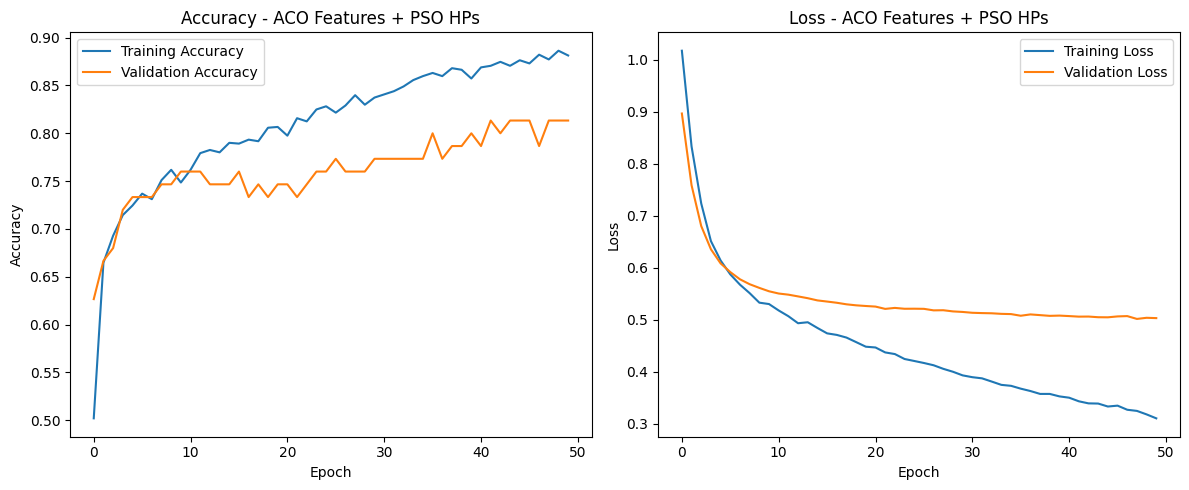

In [43]:
max_val_acc_aco, min_val_loss_aco = plot_training_history(history_aco_final, title="ACO Features + PSO HPs")

In [44]:
print("\n--- Evaluation (ACO Features + PSO HPs) ---")
test_loss_aco, test_acc_aco = final_aco_model.evaluate(X_test_sel, test_labels, verbose=0)
print(f"Test Loss: {test_loss_aco:.4f}, Test Accuracy: {test_acc_aco:.4f}")

y_pred_probs_aco = final_aco_model.predict(X_test_sel)
y_pred_aco = np.argmax(y_pred_probs_aco, axis=1)
y_true_aco = np.argmax(test_labels, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_aco, y_pred_aco, target_names=TARGET_NAMES))


--- Evaluation (ACO Features + PSO HPs) ---
Test Loss: 0.4001, Test Accuracy: 0.8502
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Classification Report:
              precision    recall  f1-score   support

    Covid-19       0.78      0.79      0.78        76
   Pneumonia       0.78      0.83      0.81        75
      Normal       1.00      0.93      0.97        76

    accuracy                           0.85       227
   macro avg       0.85      0.85      0.85       227
weighted avg       0.85      0.85      0.85       227



Overall Sensitivity (macro-averaged) = 0.8501
Overall Specificity (macro-averaged) = 0.9252


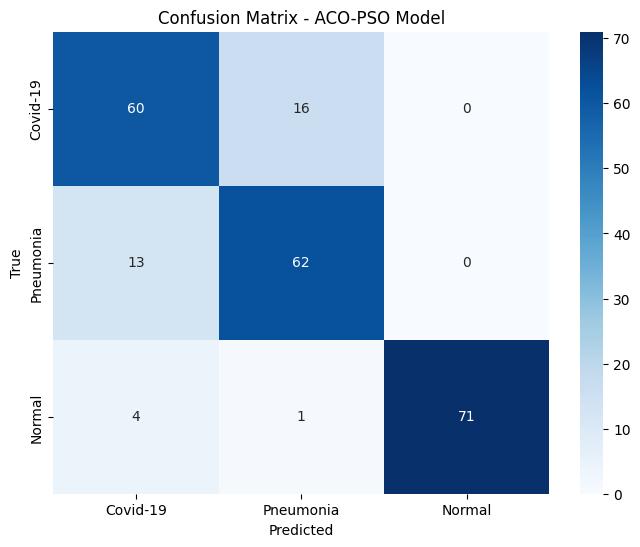

In [45]:
cm_aco = confusion_matrix(y_true_aco, y_pred_aco)
sensitivities, specificities = [], []
for i in range(len(cm_aco)):
    TP = cm_aco[i, i]; FN = cm_aco[i, :].sum() - TP
    FP = cm_aco[:, i].sum() - TP; TN = cm_aco.sum() - (TP + FN + FP)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    sensitivities.append(sensitivity); specificities.append(specificity)

sens_aco = np.mean(sensitivities)
spec_aco = np.mean(specificities)
print(f"Overall Sensitivity (macro-averaged) = {sens_aco:.4f}")
print(f"Overall Specificity (macro-averaged) = {spec_aco:.4f}")

# Plot CM
plt.figure(figsize=(8, 6))
sns.heatmap(cm_aco, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES)
plt.title(f'Confusion Matrix - ACO-PSO Model')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

## 5.6. Store results

In [46]:
optimization_summary['ACO Model (w/ PSO HPs)'] = {
    'Test Accuracy': test_acc_aco,
    'Test Loss': test_loss_aco,
    'Max Validation Accuracy': max_val_acc_aco,
    'Min Validation Loss': min_val_loss_aco,
    'Sensitivity': sens_aco,
    'Specificity': spec_aco,
    'Optimization Time (s)': aco_exec_time,
    'Final Training Time (s)': aco_train_time,
    'Total Time (s)': aco_exec_time + aco_train_time,
    'HPs': {'LR': lr_pso, 'Dropout': dropout_pso, 'Dense': dense_units_pso},
    'Features': f"{num_selected_features}/{num_features}"
}

In [47]:
optimization_summary['ACO Model (w/ PSO HPs)']

{'Test Accuracy': 0.850220263004303,
 'Test Loss': 0.400128036737442,
 'Max Validation Accuracy': 0.8133333325386047,
 'Min Validation Loss': 0.5016965866088867,
 'Sensitivity': 0.8501169590643275,
 'Specificity': 0.9251917044266295,
 'Optimization Time (s)': 1255.4467618465424,
 'Final Training Time (s)': 10.326367616653442,
 'Total Time (s)': 1265.7731294631958,
 'HPs': {'LR': 0.0004575085234040853,
  'Dropout': 0.12922144901710003,
  'Dense': 185},
 'Features': '234/512'}

# 6. Optimization 3: Simulated Annealing (SA)

## 6.1 SA Definitions

In [55]:
SA_SPACE = {
    "LR": {
        "type": "float", "min": 1e-5, "max": 1e-3, "log": True
    },
    "BATCH": {
        "type": "int", "min": 8, "max": 32, "step": 4
    },
    "DROPOUT": {
        "type": "float", "min": 0.0, "max": 0.6, "step": 0.1
    },
    "DENSE_UNITS": {
        "type": "int", "min": 16, "max": 256, "step": 16
    }
}

SA_START = {
    "LR": 1e-4, "BATCH": 16, "DROPOUT": 0.3, "DENSE_UNITS": 128
}

In [56]:
def _clip_round_sa(name, val):
    spec = SA_SPACE[name]
    
    if spec["type"] == "int":
        v = int(round(val))
        v = int(max(spec["min"], min(spec["max"], v)))
        if "step" in spec and spec["step"] > 0:
             v = spec["min"] + round((v - spec["min"]) / spec["step"]) * spec["step"]
        return int(max(spec["min"], min(spec["max"], v)))
    
    if spec["type"] == "float":
        if spec.get("log", False):
            log_min = np.log10(spec["min"]); log_max = np.log10(spec["max"])
            log_val = np.log10(max(spec["min"], min(spec["max"], float(val))))
            log_val = max(log_min, min(log_max, log_val)); v = 10 ** log_val
        else:
            v = float(max(spec["min"], min(spec["max"], float(val))))
        
        step = spec.get("step", None)
        if step is not None and step > 0:
            v = round(v / step) * step
            v = float(max(spec["min"], min(spec["max"], v)))
        return v

In [57]:
def _random_neighbor_sa(cfg):
    name = random.choice(list(SA_SPACE.keys()))
    spec = SA_SPACE[name]
    new_cfg = cfg.copy()
    
    if spec["type"] == "int":
        step = spec.get("step", 1)
        delta = random.choice([-step, step])
        new_cfg[name] = _clip_round_sa(name, cfg[name] + delta)
    
    elif spec["type"] == "float":
        if spec.get("log", False):
            log_min = np.log10(spec["min"]); log_max = np.log10(spec["max"])
            log_val = np.log10(cfg[name]); step_size = (log_max - log_min) * 0.1 
            delta = random.choice([-step_size, step_size]); new_val = 10 ** (log_val + delta)
        else:
            step = spec.get("step", (spec["max"] - spec["min"]) * 0.1)
            delta = random.choice([-step, step]); new_val = cfg[name] + delta
        
        new_cfg[name] = _clip_round_sa(name, new_val)
    
    if new_cfg[name] == cfg[name]:
        return _random_neighbor_sa(cfg) # Try again
        
    return new_cfg, name

In [58]:
def evaluate_sa_candidate(candidate, X_train, y_train, X_val, y_val, epochs):

    lr = candidate['LR']; batch = candidate['BATCH']
    dropout = candidate['DROPOUT']; dense_units = candidate['DENSE_UNITS']
    
    input_shape = X_train.shape[1:]; num_classes = y_train.shape[1]
    
    # Use the helper function to build the model
    m = build_vgg16_model(input_shape, num_classes, dropout, lr, dense_units)
    
    history = m.fit(
        X_train, y_train,
        batch_size=batch,
        epochs=epochs,
        validation_data=(X_val, y_val),
        verbose=0 
    )
    
    score = max(history.history['val_accuracy'])
    
    del m
    tf.keras.backend.clear_session()
    
    print(f"    -> Val Accuracy: {score:.4f}")
    return score

In [59]:
def simulated_annealing(X_train, y_train, X_val, y_val, sa_epochs, iters=20, T0=1.0, alpha=0.95):
    
    current_solution = SA_START.copy()
    print("\nInitializing with starting parameters:")
    for key, val in current_solution.items(): print(f"  {key}: {val}")
    
    current_accuracy = evaluate_sa_candidate(current_solution, X_train, y_train, X_val, y_val, sa_epochs)
    
    best_solution = current_solution.copy()
    best_accuracy = current_accuracy
    
    T = T0; history_sa = []
    
    print("\n--- STARTING SA ITERATIONS ---")
    
    for iteration in range(iters):
        print(f"\nITERATION {iteration + 1}/{iters}, T={T:.4f}, Best Acc={best_accuracy:.4f}")
        
        candidate, param_changed = _random_neighbor_sa(current_solution)
        print(f"  Changing param: {param_changed} -> {candidate[param_changed]}")
        
        candidate_accuracy = evaluate_sa_candidate(candidate, X_train, y_train, X_val, y_val, sa_epochs)
        
        delta = candidate_accuracy - current_accuracy
        print(f"  -> Accuracy Change (delta): {delta:.4f} (Cand: {candidate_accuracy:.4f} vs Curr: {current_accuracy:.4f})")
        
        if delta > 0:
            print(f"  ACCEPTED: Better accuracy found!")
            current_solution = candidate; current_accuracy = candidate_accuracy
        else:
            acceptance_prob = np.exp(delta / T) if T > 0.001 else 0
            rand_val = np.random.rand()
            print(f"  Worse solution. Prob: {acceptance_prob:.4f} (Rand: {rand_val:.4f})")
            
            if rand_val < acceptance_prob:
                print(f"  ACCEPTED: Accepted worse solution probabilistically.")
                current_solution = candidate; current_accuracy = candidate_accuracy
            else:
                print(f"  REJECTED: Worse solution rejected.")
        
        if current_accuracy > best_accuracy:
            print(f"  *** NEW BEST OVERALL SOLUTION FOUND! ***")
            best_solution = current_solution.copy(); best_accuracy = current_accuracy
        
        T *= alpha
        history_sa.append(best_accuracy)
    
    print("\nBest Parameters Found (SA):")
    for key, val in best_solution.items(): print(f"  {key}: {val}")
    print(f"\nBest Validation Accuracy (SA): {best_accuracy:.4f}")
    
    return best_solution, best_accuracy, history_sa

## 6.2 SA Execution

In [60]:
sa_exec_start_time = time.time()

SA_EVAL_EPOCHS = 5 
SA_ITERATIONS = 25

best_params_sa, best_acc_sa, history_sa_run = simulated_annealing(
    train_images, train_labels, val_images, val_labels, 
    sa_epochs=SA_EVAL_EPOCHS,
    iters=SA_ITERATIONS,
    T0=1.0,
    alpha=0.9
)
sa_exec_time = time.time() - sa_exec_start_time
print(f"--- SA Optimization Finished in {sa_exec_time:.2f} seconds ---")


Initializing with starting parameters:
  LR: 0.0001
  BATCH: 16
  DROPOUT: 0.3
  DENSE_UNITS: 128
    -> Val Accuracy: 0.6800

--- STARTING SA ITERATIONS ---

ITERATION 1/25, T=1.0000, Best Acc=0.6800
  Changing param: BATCH -> 12
    -> Val Accuracy: 0.7333
  -> Accuracy Change (delta): 0.0533 (Cand: 0.7333 vs Curr: 0.6800)
  ACCEPTED: Better accuracy found!
  *** NEW BEST OVERALL SOLUTION FOUND! ***

ITERATION 2/25, T=0.9000, Best Acc=0.7333
  Changing param: LR -> 0.00015848931924611142
    -> Val Accuracy: 0.7867
  -> Accuracy Change (delta): 0.0533 (Cand: 0.7867 vs Curr: 0.7333)
  ACCEPTED: Better accuracy found!
  *** NEW BEST OVERALL SOLUTION FOUND! ***

ITERATION 3/25, T=0.8100, Best Acc=0.7867
  Changing param: LR -> 0.0002511886431509582
    -> Val Accuracy: 0.8267
  -> Accuracy Change (delta): 0.0400 (Cand: 0.8267 vs Curr: 0.7867)
  ACCEPTED: Better accuracy found!
  *** NEW BEST OVERALL SOLUTION FOUND! ***

ITERATION 4/25, T=0.7290, Best Acc=0.8267
  Changing param: DENSE_

## 6.3 Final SA Model Training & Evaluation

In [61]:
print("\n--- Final VGG16 (SA) Model Training ---")

lr_sa = best_params_sa['LR']
dropout_sa = best_params_sa['DROPOUT']
dense_units_sa = best_params_sa['DENSE_UNITS']
epochs_sa = DEFAULT_HYPERPARAMS['epochs'] # Full training run

final_model_sa = build_vgg16_model(
    DEFAULT_HYPERPARAMS['input_shape'],
    DEFAULT_HYPERPARAMS['num_classes'],
    dropout_sa, 
    lr_sa, 
    dense_units_sa
)

print(f"Training VGG16 (SA) model for {epochs_sa} epochs with optimal HPs:")
print(f"LR: {lr_sa:.6f}, Dropout: {dropout_sa:.4f}, Dense: {dense_units_sa}")
print(f"Using Generator Batch Size: {DEFAULT_HYPERPARAMS['batch_size']}")


--- Final VGG16 (SA) Model Training ---
Training VGG16 (SA) model for 50 epochs with optimal HPs:
LR: 0.000631, Dropout: 0.2000, Dense: 64
Using Generator Batch Size: 16


In [62]:
sa_train_start_time = time.time()
history_sa_final = final_model_sa.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs_sa,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1 
)
sa_train_time = time.time() - sa_train_start_time
print(f"--- SA Final Training Finished in {sa_train_time:.2f} seconds ---")

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - accuracy: 0.4523 - loss: 1.0349 - val_accuracy: 0.6267 - val_loss: 0.7981
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.6290 - loss: 0.7834 - val_accuracy: 0.6933 - val_loss: 0.6786
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.6969 - loss: 0.6624 - val_accuracy: 0.6933 - val_loss: 0.6354
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.6765 - loss: 0.6344 - val_accuracy: 0.7467 - val_loss: 0.6015
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.7175 - loss: 0.5917 - val_accuracy: 0.6667 - val_loss: 0.5920
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.7227 - loss: 0.5950 - val_accuracy: 0.7200 - val_loss: 0.5793
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.7064 - loss: 0.5581 - val_accuracy: 0.7467 - val_loss: 0.5708
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.7410 - loss: 0.5168 - val_accu

## 6.4 Evaluation (using helper functions)

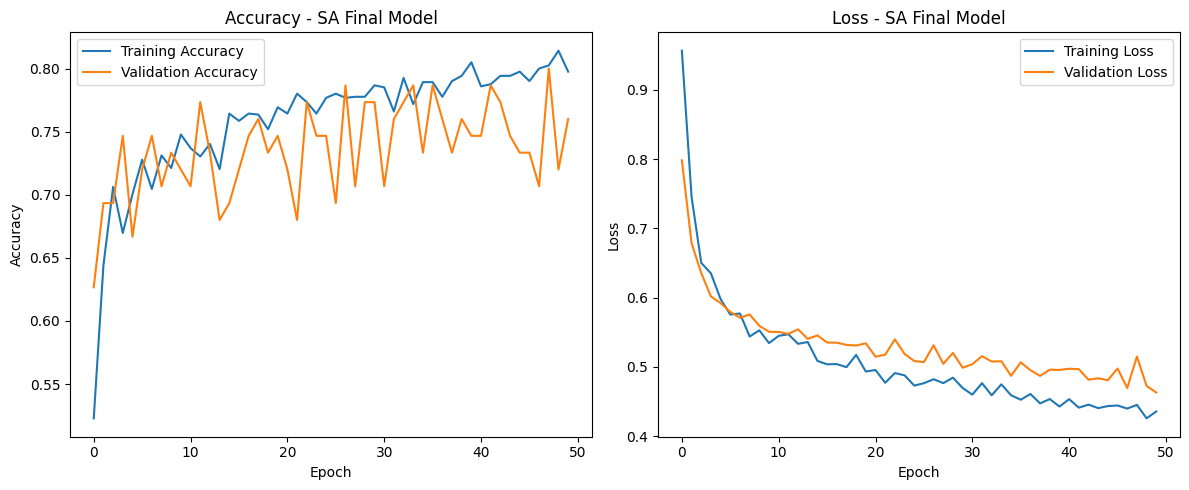


--- SA Final Model ---
Test Loss: 0.4009, Test Accuracy: 0.8502
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step

Classification Report:
              precision    recall  f1-score   support

    Covid-19       0.78      0.82      0.79        76
   Pneumonia       0.80      0.80      0.80        75
      Normal       0.99      0.93      0.96        76

    accuracy                           0.85       227
   macro avg       0.85      0.85      0.85       227
weighted avg       0.85      0.85      0.85       227

Overall Sensitivity (macro-averaged) = 0.8500
Overall Specificity (macro-averaged) = 0.9252


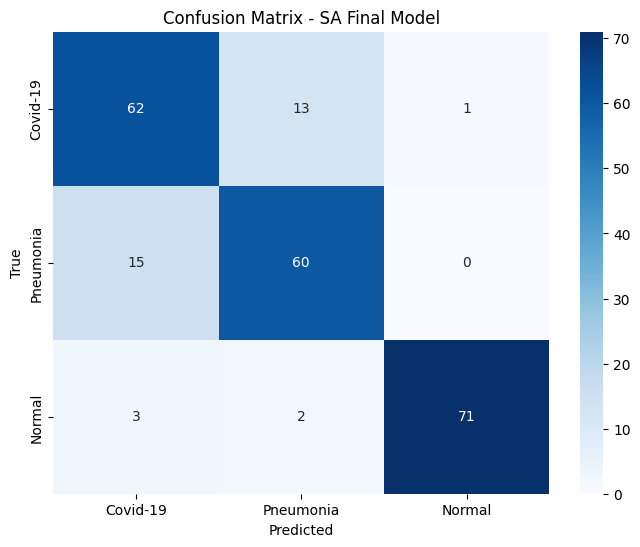

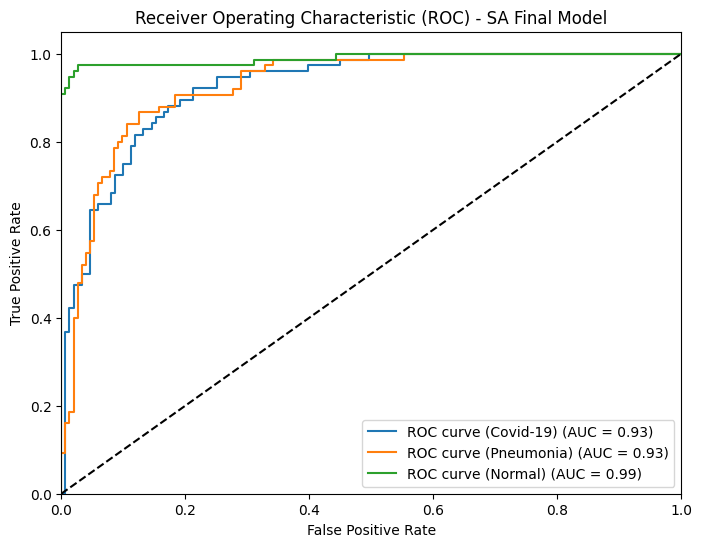

In [63]:
max_val_acc_sa, min_val_loss_sa = plot_training_history(history_sa_final, title="SA Final Model")
test_loss_sa, test_acc_sa, sens_sa, spec_sa = evaluate_model(final_model_sa, test_generator, TARGET_NAMES, title="SA Final Model")

## 6.5 Store results

In [64]:
optimization_summary['Simulated Annealing'] = {
    'Test Accuracy': test_acc_sa,
    'Test Loss': test_loss_sa,
    'Max Validation Accuracy': max_val_acc_sa,
    'Min Validation Loss': min_val_loss_sa,
    'Sensitivity': sens_sa,
    'Specificity': spec_sa,
    'Optimization Time (s)': sa_exec_time,
    'Final Training Time (s)': sa_train_time,
    'Total Time (s)': sa_exec_time + sa_train_time,
    'HPs': {'LR': lr_sa, 'Dropout': dropout_sa, 'Dense': dense_units_sa}
}

In [65]:
optimization_summary['Simulated Annealing']

{'Test Accuracy': 0.850220263004303,
 'Test Loss': 0.4009243845939636,
 'Max Validation Accuracy': 0.800000011920929,
 'Min Validation Loss': 0.46282175183296204,
 'Sensitivity': 0.85,
 'Specificity': 0.9251626583013826,
 'Optimization Time (s)': 1456.714602947235,
 'Final Training Time (s)': 677.7236406803131,
 'Total Time (s)': 2134.438243627548,
 'HPs': {'LR': 0.0006309573444801943, 'Dropout': 0.2, 'Dense': 64}}

# 7. Optimization 4: Tabu Search (TS)

## 7.1 TS Definitions

In [26]:
TS_SEARCH_SPACE = {
    'learning_rate': (1e-5, 1e-3, 1e-5),
    'batch_size': (8, 32, 4),
    'dense_units': (16, 256, 32),
    'dropout_rate': (0.0, 0.6, 0.1)
}

TS_INITIAL_SOLUTION = {
    'learning_rate': 1e-4,
    'batch_size': 16,
    'dense_units': 128,
    'dropout_rate': 0.3
}

In [27]:
def evaluate_solution_ts(solution_params, X_train, y_train, X_val, y_val, 
                         eval_epochs=5, overfit_penalty_factor=0.5):
    """Evaluates a Tabu Search solution. Uses NumPy arrays."""
    
    # We clear session *after* the model is deleted
    
    batch_size = int(solution_params['batch_size'])
    learning_rate = float(solution_params['learning_rate'])
    dense_units = int(solution_params['dense_units'])
    dropout_rate = float(solution_params['dropout_rate'])
    
    input_shape = X_train.shape[1:]; num_classes = y_train.shape[1]

    model = build_vgg16_model(
        input_shape=input_shape,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        dense_units=dense_units
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=eval_epochs,
        verbose=0 
    )

    best_val_acc = max(history.history['val_accuracy'])
    best_epoch_index = np.argmax(history.history['val_accuracy'])
    train_acc_at_best = history.history['accuracy'][best_epoch_index]
    overfit_gap = max(0, train_acc_at_best - best_val_acc)
    score = best_val_acc - (overfit_gap * overfit_penalty_factor)

    del model
    del history
    gc.collect()
    tf.keras.backend.clear_session()

    return score

In [28]:
def get_neighborhood_ts(current_solution, search_space):
    neighbors = []
    for param, (min_val, max_val, step) in search_space.items():
        current_val = current_solution[param]

        neighbor_val_up = current_val + step
        if neighbor_val_up <= max_val:
            neighbor_up = copy.deepcopy(current_solution)
            neighbor_up[param] = neighbor_val_up
            neighbors.append(neighbor_up)

        neighbor_val_down = current_val - step
        if neighbor_val_down >= min_val:
            neighbor_down = copy.deepcopy(current_solution)
            neighbor_down[param] = neighbor_val_down
            neighbors.append(neighbor_down)

    for n in neighbors:
        n['batch_size'] = int(n['batch_size'])
        n['dense_units'] = int(n['dense_units'])
        n['dropout_rate'] = round(n['dropout_rate'], 2)
        n['learning_rate'] = round(n['learning_rate'], 6)
    return neighbors

In [29]:
def generate_random_solution_ts(search_space):
    new_solution = {}
    for param, (min_val, max_val, step) in search_space.items():
        if isinstance(step, int): # For int params
            num_steps = int((max_val - min_val) / step)
            random_step = random.randint(0, num_steps)
            new_solution[param] = min_val + random_step * step
        else:
            num_steps = int(round((max_val - min_val) / step))
            random_step = random.randint(0, num_steps)
            new_val = min_val + random_step * step
            new_solution[param] = round(new_val, 8)
    
    new_solution['batch_size'] = int(new_solution['batch_size'])
    new_solution['dense_units'] = int(new_solution['dense_units'])
    new_solution['dropout_rate'] = float(new_solution['dropout_rate'])
    new_solution['learning_rate'] = float(new_solution['learning_rate'])
    return new_solution

In [30]:
def tabu_search_optimizer_ts(initial_solution, search_space, max_iterations, 
                             tabu_size, eval_epochs, 
                             X_train, y_train, X_val, y_val,
                             max_stuck_iterations=10):
    
    current_solution = initial_solution
    best_solution = current_solution
    iterations_without_improvement = 0

    best_score = evaluate_solution_ts(best_solution, X_train, y_train, X_val, y_val, eval_epochs)
    print(f"Initial Solution: {current_solution}, Score: {best_score:.4f}")

    tabu_list = deque(maxlen=tabu_size)
    tabu_list.append(frozenset(current_solution.items()))

    for i in range(max_iterations):
        print(f"\n===== TS Iteration {i+1}/{max_iterations} =====")
        
        neighborhood = get_neighborhood_ts(current_solution, search_space)
        best_neighbor = None
        best_neighbor_score = -1.0 

        for neighbor in neighborhood:
            neighbor_score = evaluate_solution_ts(neighbor, X_train, y_train, X_val, y_val, eval_epochs)
            hashable_neighbor = frozenset(neighbor.items())

            if hashable_neighbor in tabu_list:
                if neighbor_score > best_score:
                    print(f"Aspiration Criteria Met! Tabu solution {neighbor} is new best.")
                    best_neighbor = neighbor
                    best_neighbor_score = neighbor_score
            else:
                if neighbor_score > best_neighbor_score:
                    best_neighbor = neighbor
                    best_neighbor_score = neighbor_score
        
        if best_neighbor is None:
            print("No valid (or aspirational) neighbors found. Stopping search.")
            break

        current_solution = best_neighbor
        tabu_list.append(frozenset(current_solution.items()))

        if best_neighbor_score > best_score:
            best_solution = best_neighbor
            best_score = best_neighbor_score
            print(f"*** New Global Best Solution Found! Score: {best_score:.4f} ***")
            print(f"*** {best_solution} ***")
            iterations_without_improvement = 0
        else:
            iterations_without_improvement += 1

        print(f"Current Solution: {current_solution}")
        print(f"Best Score so far: {best_score:.4f}")
        print(f"Iterations without improvement: {iterations_without_improvement}")

        if iterations_without_improvement >= max_stuck_iterations:
            print(f"\n!!! STUCK for {iterations_without_improvement} iterations. Diversifying...")
            current_solution = generate_random_solution_ts(search_space)
            print(f"Jumping to new random solution: {current_solution}")
            new_score = evaluate_solution_ts(current_solution, X_train, y_train, X_val, y_val, eval_epochs)

            if new_score > best_score:
                best_solution = current_solution; best_score = new_score
                print(f"*** Random jump found a new global best! Score: {best_score:.4f} ***")

            iterations_without_improvement = 0
            tabu_list.clear()
            tabu_list.append(frozenset(current_solution.items()))

    print("\n===== Tabu Search Finished =====")
    print(f"Best solution found: {best_solution}")
    print(f"Best score: {best_score:.4f}")
    return best_solution, best_score

## 7.2 TS Execution

In [32]:
ts_exec_start_time = time.time()

TS_MAX_ITERATIONS = 20 # Increased from 2 for a better search
TS_TABU_SIZE = 5
TS_EVAL_EPOCHS = 5
TS_MAX_STUCK_ITERATIONS = 8

best_hyperparams_ts, best_model_score_ts = tabu_search_optimizer_ts(
    TS_INITIAL_SOLUTION,
    TS_SEARCH_SPACE,
    max_iterations=TS_MAX_ITERATIONS,
    tabu_size=TS_TABU_SIZE,
    eval_epochs=TS_EVAL_EPOCHS,
    X_train=train_images, 
    y_train=train_labels,
    X_val=val_images, 
    y_val=val_labels,
    max_stuck_iterations=TS_MAX_STUCK_ITERATIONS
)

ts_exec_time = time.time() - ts_exec_start_time
print(f"--- TS Optimization Finished in {ts_exec_time:.2f} seconds ---")

I0000 00:00:1761893726.945554      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761893726.946159      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1761893732.899646     103 service.cc:148] XLA service 0x79d1d800f080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761893732.900696     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761893732.900715     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761893733.285204     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761893740.901707     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Initial Solution: {'learning_rate': 0.0001, 'batch_size': 16, 'dense_units': 128, 'dropout_rate': 0.3}, Score: 0.7600

===== TS Iteration 1/20 =====
Current Solution: {'learning_rate': 0.0001, 'batch_size': 16, 'dense_units': 96, 'dropout_rate': 0.3}
Best Score so far: 0.7600
Iterations without improvement: 1

===== TS Iteration 2/20 =====
Current Solution: {'learning_rate': 9e-05, 'batch_size': 16, 'dense_units': 96, 'dropout_rate': 0.3}
Best Score so far: 0.7600
Iterations without improvement: 2

===== TS Iteration 3/20 =====
*** New Global Best Solution Found! Score: 0.8000 ***
*** {'learning_rate': 9e-05, 'batch_size': 12, 'dense_units': 96, 'dropout_rate': 0.3} ***
Current Solution: {'learning_rate': 9e-05, 'batch_size': 12, 'dense_units': 96, 'dropout_rate': 0.3}
Best Score so far: 0.8000
Iterations without improvement: 0

===== TS Iteration 4/20 =====
Current Solution: {'learning_rate': 9e-05, 'batch_size': 8, 'dense_units': 96, 'dropout_rate': 0.3}
Best Score so far: 0.8000
Ite

In [31]:
import gc


### 7.3 Final TS Model Training & Evaluation

In [33]:
lr_ts = best_hyperparams_ts['learning_rate']
dropout_ts = best_hyperparams_ts['dropout_rate']
dense_units_ts = best_hyperparams_ts['dense_units']
epochs_ts = DEFAULT_HYPERPARAMS['epochs']

best_model_ts = build_vgg16_model(
    DEFAULT_HYPERPARAMS['input_shape'],
    DEFAULT_HYPERPARAMS['num_classes'],
    dropout_ts, 
    lr_ts, 
    dense_units_ts
)

print(f"Training VGG16 (TS) model for {epochs_ts} epochs with optimal HPs:")
print(f"LR: {lr_ts:.6f}, Dropout: {dropout_ts:.4f}, Dense: {dense_units_ts}")
print(f"Using Generator Batch Size: {DEFAULT_HYPERPARAMS['batch_size']}")

Training VGG16 (TS) model for 50 epochs with optimal HPs:
LR: 0.000610, Dropout: 0.5000, Dense: 144
Using Generator Batch Size: 16


## **Use the new generators for final training**

In [34]:
ts_train_start_time = time.time()
history_ts = best_model_ts.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs_ts,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1 
)
ts_train_time = time.time() - ts_train_start_time
print(f"--- TS Final Training Finished in {ts_train_time:.2f} seconds ---")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 201ms/step - accuracy: 0.4067 - loss: 1.1136 - val_accuracy: 0.6133 - val_loss: 0.7896
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - accuracy: 0.6479 - loss: 0.7904 - val_accuracy: 0.6667 - val_loss: 0.6799
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.6689 - loss: 0.6813 - val_accuracy: 0.7200 - val_loss: 0.6302
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.6752 - loss: 0.6169 - val_accuracy: 0.6667 - val_loss: 0.6262
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - accuracy: 0.6643 - loss: 0.6281 - val_accuracy: 0.6667 - val_loss: 0.6147
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.7134 - loss: 0.5816 - val_accuracy: 0.6533 - val_loss: 0.5952
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.7172 - loss: 0.6024 - val_accuracy: 0.6533 - val_loss: 0.6044
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.6953 - loss: 0.5719 - val_accu

## 7.4 Evaluation (using helper functions)

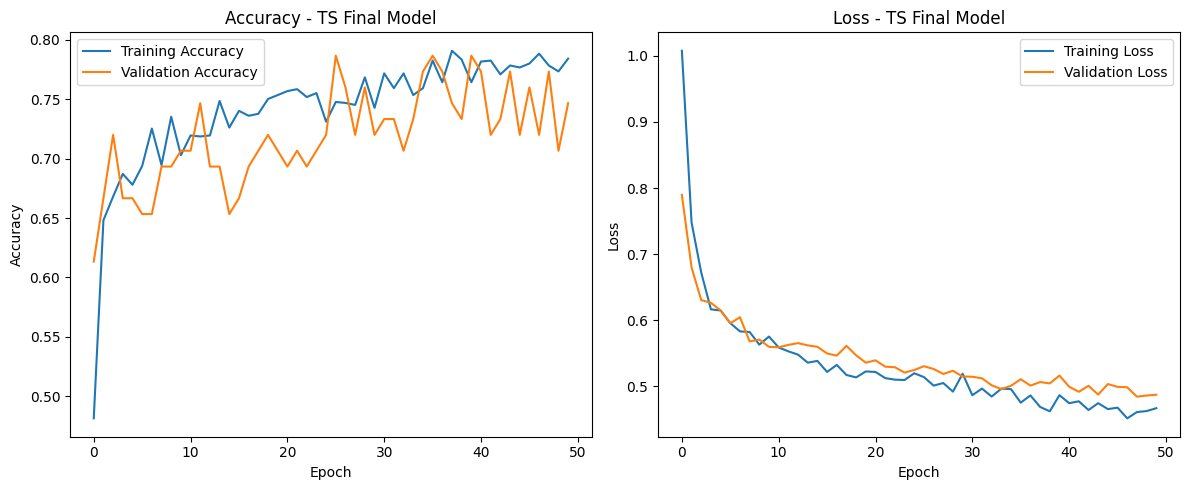


--- TS Final Model ---
Test Loss: 0.4497, Test Accuracy: 0.7930
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step

Classification Report:
              precision    recall  f1-score   support

    Covid-19       0.65      0.93      0.76        76
   Pneumonia       0.83      0.53      0.65        75
      Normal       1.00      0.91      0.95        76

    accuracy                           0.79       227
   macro avg       0.83      0.79      0.79       227
weighted avg       0.83      0.79      0.79       227

Overall Sensitivity (macro-averaged) = 0.7918
Overall Specificity (macro-averaged) = 0.8964


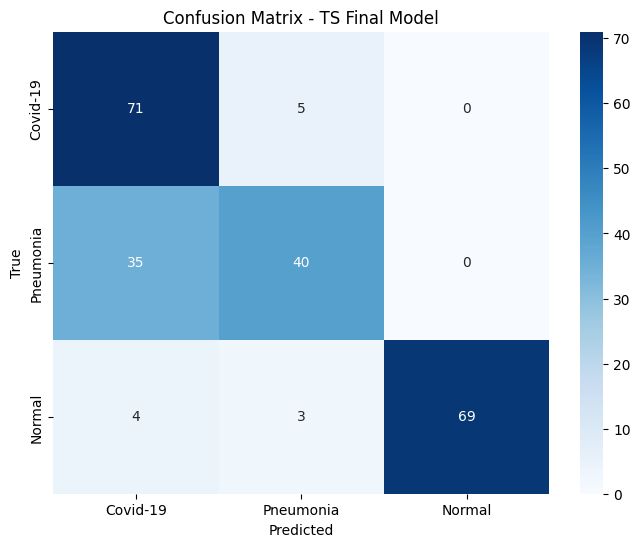

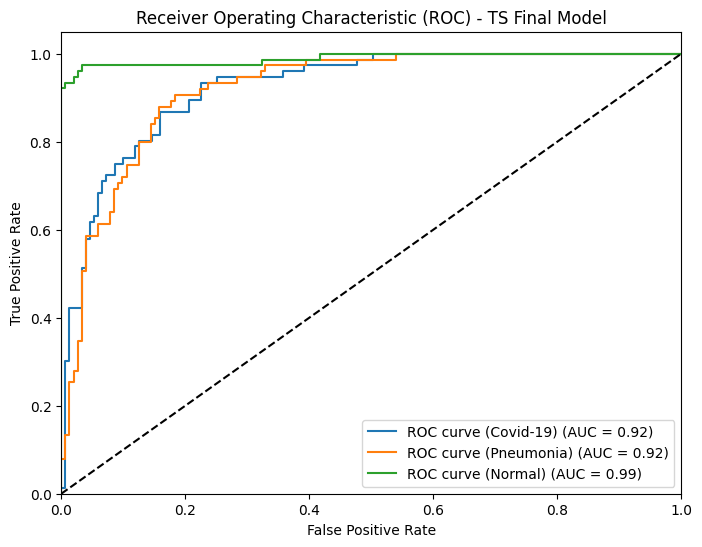

In [35]:
max_val_acc_ts, min_val_loss_ts = plot_training_history(history_ts, title="TS Final Model")
test_loss_ts, test_acc_ts, sens_ts, spec_ts = evaluate_model(best_model_ts, test_generator, TARGET_NAMES, title="TS Final Model")

## 7.5 Store results

In [36]:
optimization_summary['Tabu Search'] = {
    'Test Accuracy': test_acc_ts,
    'Test Loss': test_loss_ts,
    'Max Validation Accuracy': max_val_acc_ts,
    'Min Validation Loss': min_val_loss_ts,
    'Sensitivity': sens_ts,
    'Specificity': spec_ts,
    'Optimization Time (s)': ts_exec_time,
    'Final Training Time (s)': ts_train_time,
    'Total Time (s)': ts_exec_time + ts_train_time,
    'HPs': {'LR': lr_ts, 'Dropout': dropout_ts, 'Dense': dense_units_ts}
}

In [37]:
optimization_summary['Tabu Search']

{'Test Accuracy': 0.7929515242576599,
 'Test Loss': 0.4496607482433319,
 'Max Validation Accuracy': 0.7866666913032532,
 'Min Validation Loss': 0.48412227630615234,
 'Sensitivity': 0.791812865497076,
 'Specificity': 0.8963634251190892,
 'Optimization Time (s)': 8719.798564195633,
 'Final Training Time (s)': 679.0669524669647,
 'Total Time (s)': 9398.865516662598,
 'HPs': {'LR': 0.00061, 'Dropout': 0.5, 'Dense': 144}}

# 8. Optimization 5: Hill Climbing (Random-Restart)

## 8.1 HC Definitions

In [39]:
HC_SPACE = {
    "LR": {"type": "float", "min": 1e-5, "max": 1e-3, "log": True},
    "BATCH": {"type": "int", "min": 8, "max": 32, "step": 4},
    "DROPOUT": {"type": "float", "min": 0.0, "max": 0.6, "step": 0.1},
    "DENSE_UNITS": {"type": "int", "min": 16, "max": 256, "step": 16}
}

HC_START = {
    "LR": 1e-4, "BATCH": 16, "DROPOUT": 0.3, "DENSE_UNITS": 128
}

In [40]:
def initialize_random_hc(space_def):
    
    cfg = {}
    for name, spec in space_def.items():
        if spec["type"] == "int":
            values = np.arange(spec["min"], spec["max"] + 1, spec["step"])
            cfg[name] = int(random.choice(values))
        elif spec["type"] == "float":
            if spec.get("log", False):
                log_min = np.log10(spec["min"]); log_max = np.log10(spec["max"])
                cfg[name] = 10 ** random.uniform(log_min, log_max)
            else:
                step = spec.get("step", 0.1)
                values = np.arange(spec["min"], spec["max"] + step, step)
                cfg[name] = float(random.choice(values))
    cfg['BATCH'] = int(cfg['BATCH'])
    cfg['DENSE_UNITS'] = int(cfg['DENSE_UNITS'])
    return cfg

In [41]:
def evaluate_parameters_hc(candidate, X_train, y_train, X_val, y_val, epochs):
    
    print("\nEVALUATING (HC):")
    for k, v in candidate.items(): print(f"  {k}: {v}")
        
    tf.keras.backend.clear_session()
    lr = candidate['LR']; batch = int(candidate['BATCH'])
    dropout = candidate['DROPOUT']; dense_units = int(candidate['DENSE_UNITS'])
    
    input_shape = X_train.shape[1:]; num_classes = y_train.shape[1]

    # Use the helper function to build the model
    model = build_vgg16_model(
        input_shape, num_classes, dropout, lr, dense_units
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch,
        epochs=epochs,
        verbose=0
    )
    val_acc = max(history.history['val_accuracy'])
    print(f"  -> Validation Accuracy: {val_acc:.4f}")
    
    del model
    tf.keras.backend.clear_session()
    
    return val_acc

In [42]:
def model_optimization_hc(start_solution, X_train, y_train, X_val, y_val, 
                          epochs, random_restarts=3):
    
    # Evaluate the starting solution
    best_acc = evaluate_parameters_hc(start_solution, X_train, y_train, X_val, y_val, epochs)
    best_combo = start_solution.copy()

    print(f"\nInitial Accuracy = {best_acc:.4f}")
    print(f"Initial Combo = {best_combo}")

    # Run the random search
    for i in range(random_restarts):
        print(f"\n--- Random Restart #{i+1}/{random_restarts} ---")
        combo = initialize_random_hc(HC_SPACE)
        acc = evaluate_parameters_hc(combo, X_train, y_train, X_val, y_val, epochs)

        if acc > best_acc:
            best_acc = acc
            best_combo = combo.copy()
            print(f"*** New Best Found! Acc: {best_acc:.4f} ***")

    print(f"\n--- Random Search (HC) Finished ---")
    print(f"Best Combo: {best_combo}")
    print(f"Best Accuracy: {best_acc:.4f}")
    return best_combo

## 8.2 HC Execution

In [43]:
hc_exec_start_time = time.time()

HC_EVAL_EPOCHS = 5  
HC_RANDOM_RESTARTS = 25 # Increased for a better search

best_params_hc = model_optimization_hc(
    HC_START, 
    train_images, train_labels, 
    val_images, val_labels, 
    epochs=HC_EVAL_EPOCHS,
    random_restarts=HC_RANDOM_RESTARTS
)
hc_exec_time = time.time() - hc_exec_start_time
print(f"--- HC (RS) Optimization Finished in {hc_exec_time:.2f} seconds ---")


EVALUATING (HC):
  LR: 0.0001
  BATCH: 16
  DROPOUT: 0.3
  DENSE_UNITS: 128
  -> Validation Accuracy: 0.7200

Initial Accuracy = 0.7200
Initial Combo = {'LR': 0.0001, 'BATCH': 16, 'DROPOUT': 0.3, 'DENSE_UNITS': 128}

--- Random Restart #1/25 ---

EVALUATING (HC):
  LR: 0.0004386815597832366
  BATCH: 8
  DROPOUT: 0.4
  DENSE_UNITS: 96
  -> Validation Accuracy: 0.8133
*** New Best Found! Acc: 0.8133 ***

--- Random Restart #2/25 ---

EVALUATING (HC):
  LR: 2.949325758691666e-05
  BATCH: 12
  DROPOUT: 0.6000000000000001
  DENSE_UNITS: 144
  -> Validation Accuracy: 0.6800

--- Random Restart #3/25 ---

EVALUATING (HC):
  LR: 9.6678460594391e-05
  BATCH: 8
  DROPOUT: 0.6000000000000001
  DENSE_UNITS: 32
  -> Validation Accuracy: 0.6400

--- Random Restart #4/25 ---

EVALUATING (HC):
  LR: 0.00010526094660567365
  BATCH: 20
  DROPOUT: 0.1
  DENSE_UNITS: 80
  -> Validation Accuracy: 0.6667

--- Random Restart #5/25 ---

EVALUATING (HC):
  LR: 0.00024916620419427455
  BATCH: 20
  DROPOUT: 0.2

## 8.3 Final HC Model Training & Evaluation

In [44]:
lr_hc = best_params_hc['LR']
dropout_hc = best_params_hc['DROPOUT']
dense_units_hc = best_params_hc['DENSE_UNITS']
epochs_hc = DEFAULT_HYPERPARAMS['epochs']

final_model_hc = build_vgg16_model(
    DEFAULT_HYPERPARAMS['input_shape'], 
    DEFAULT_HYPERPARAMS['num_classes'], 
    dropout_hc, 
    lr_hc, 
    dense_units_hc
)

print(f"Training VGG16 (HC/RS) model for {epochs_hc} epochs with optimal HPs:")
print(f"LR: {lr_hc:.6f}, Dropout: {dropout_hc:.4f}, Dense: {dense_units_hc}")
print(f"Using Generator Batch Size: {DEFAULT_HYPERPARAMS['batch_size']}")

Training VGG16 (HC/RS) model for 50 epochs with optimal HPs:
LR: 0.000909, Dropout: 0.1000, Dense: 64
Using Generator Batch Size: 16


## **Use the new generators for final training**

In [45]:
hc_train_start_time = time.time()
history_hc_final = final_model_hc.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs_hc,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1 
)
hc_train_time = time.time() - hc_train_start_time
print(f"--- HC (RS) Final Training Finished in {hc_train_time:.2f} seconds ---")

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 201ms/step - accuracy: 0.4874 - loss: 0.9990 - val_accuracy: 0.6133 - val_loss: 0.7364
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.6806 - loss: 0.7010 - val_accuracy: 0.7067 - val_loss: 0.6317
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.6699 - loss: 0.6228 - val_accuracy: 0.7200 - val_loss: 0.6010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.7156 - loss: 0.6047 - val_accuracy: 0.6800 - val_loss: 0.5846
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.7147 - loss: 0.5697 - val_accuracy: 0.6933 - val_loss: 0.6030
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.7198 - loss: 0.5653 - val_accuracy: 0.6933 - val_loss: 0.5921
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.6981 - loss: 0.5563 - val_accuracy: 0.6800 - val_loss: 0.6164
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.6884 - loss: 0.5601 - val_accu

## 8.4 Evaluation (using helper functions)

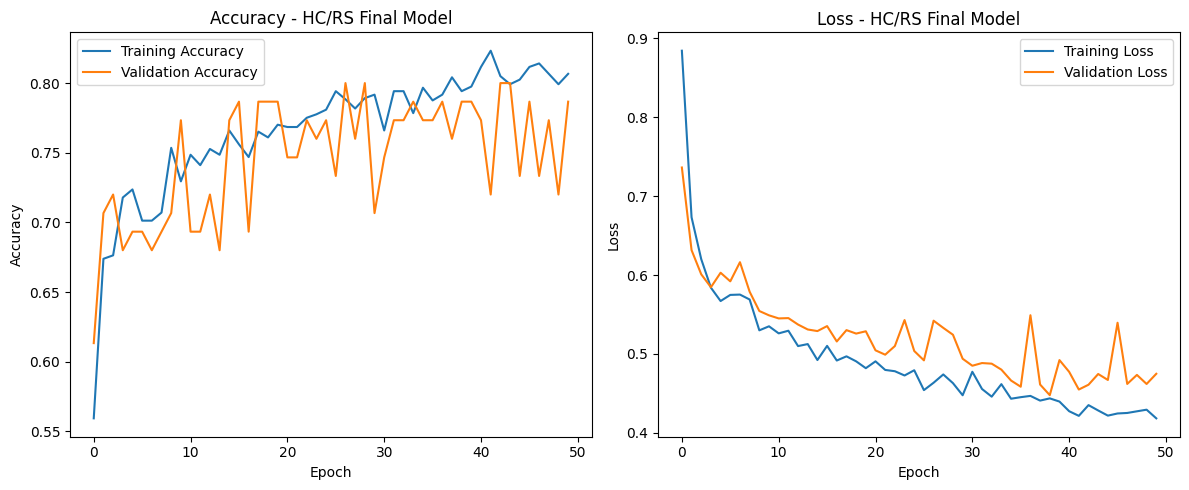


--- HC/RS Final Model ---
Test Loss: 0.4389, Test Accuracy: 0.7797
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step

Classification Report:
              precision    recall  f1-score   support

    Covid-19       0.61      0.96      0.74        76
   Pneumonia       0.92      0.44      0.59        75
      Normal       1.00      0.93      0.97        76

    accuracy                           0.78       227
   macro avg       0.84      0.78      0.77       227
weighted avg       0.84      0.78      0.77       227

Overall Sensitivity (macro-averaged) = 0.7782
Overall Specificity (macro-averaged) = 0.8897


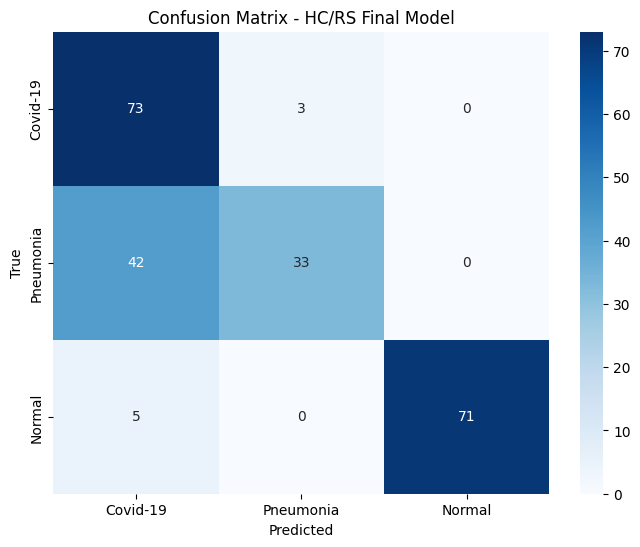

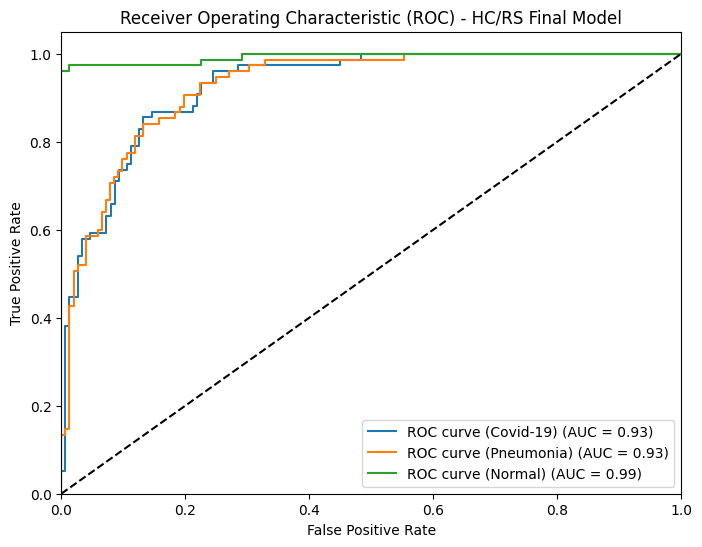

In [46]:
max_val_acc_hc, min_val_loss_hc = plot_training_history(history_hc_final, title="HC/RS Final Model")
test_loss_hc, test_acc_hc, sens_hc, spec_hc = evaluate_model(final_model_hc, test_generator, TARGET_NAMES, title="HC/RS Final Model")

# 8.5 Store results
optimization_summary['Hill Climbing (RS)'] = {
    'Test Accuracy': test_acc_hc,
    'Test Loss': test_loss_hc,
    'Max Validation Accuracy': max_val_acc_hc,
    'Min Validation Loss': min_val_loss_hc,
    'Sensitivity': sens_hc,
    'Specificity': spec_hc,
    'Optimization Time (s)': hc_exec_time,
    'Final Training Time (s)': hc_train_time,
    'Total Time (s)': hc_exec_time + hc_train_time,
    'HPs': {'LR': lr_hc, 'Dropout': dropout_hc, 'Dense': dense_units_hc}
}

In [47]:
optimization_summary['Hill Climbing (RS)']

{'Test Accuracy': 0.7797356843948364,
 'Test Loss': 0.43885937333106995,
 'Max Validation Accuracy': 0.800000011920929,
 'Min Validation Loss': 0.44778701663017273,
 'Sensitivity': 0.7782456140350877,
 'Specificity': 0.8896682932496804,
 'Optimization Time (s)': 1586.3205902576447,
 'Final Training Time (s)': 668.3206045627594,
 'Total Time (s)': 2254.641194820404,
 'HPs': {'LR': 0.0009089602756450815, 'Dropout': 0.1, 'Dense': 64}}

# 9. Final Optimization Summary

In [49]:
for technique, metrics in optimization_summary.items():
    print(f"\n--- {technique} ---")
    for key, value in metrics.items():
        if isinstance(value, float):
            print(f"  {key:<28}: {value:.4f}")
        elif isinstance(value, dict):
            # Format HPs for readability
            hps_str = ", ".join([f"{k}: {v:.1e}" if (isinstance(v, float) and k == 'LR') else f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}" for k, v in value.items()])
            print(f"  {key:<28}: {hps_str}")
        else:
            print(f"  {key:<28}: {value}")
    print("-"*40)


--- Tabu Search ---
  Test Accuracy               : 0.7930
  Test Loss                   : 0.4497
  Max Validation Accuracy     : 0.7867
  Min Validation Loss         : 0.4841
  Sensitivity                 : 0.7918
  Specificity                 : 0.8964
  Optimization Time (s)       : 8719.7986
  Final Training Time (s)     : 679.0670
  Total Time (s)              : 9398.8655
  HPs                         : LR: 6.1e-04, Dropout: 0.500, Dense: 144
----------------------------------------

--- Hill Climbing (RS) ---
  Test Accuracy               : 0.7797
  Test Loss                   : 0.4389
  Max Validation Accuracy     : 0.8000
  Min Validation Loss         : 0.4478
  Sensitivity                 : 0.7782
  Specificity                 : 0.8897
  Optimization Time (s)       : 1586.3206
  Final Training Time (s)     : 668.3206
  Total Time (s)              : 2254.6412
  HPs                         : LR: 9.1e-04, Dropout: 0.100, Dense: 64
----------------------------------------


Plot saved to /kaggle/working/ts_hc_sa_comparison.png


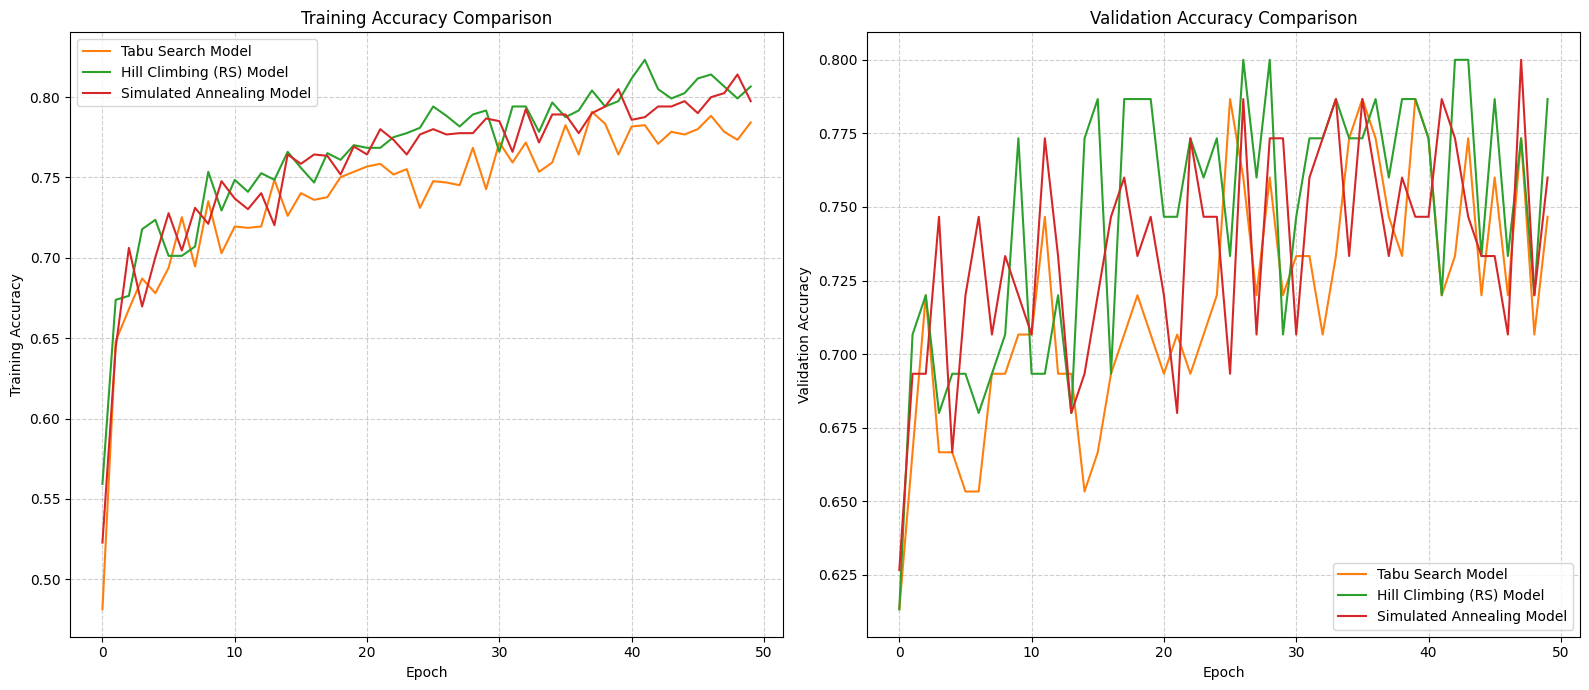

In [76]:
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.plot(history_ts.history['accuracy'], label='Tabu Search Model', color='tab:orange')
plt.plot(history_hc_final.history['accuracy'], label='Hill Climbing (RS) Model', color='tab:green')
plt.plot(history_sa_final.history['accuracy'], label='Simulated Annealing Model', color='tab:red')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(history_ts.history['val_accuracy'], label='Tabu Search Model', color='tab:orange')
plt.plot(history_hc_final.history['val_accuracy'], label='Hill Climbing (RS) Model', color='tab:green')
plt.plot(history_sa_final.history['val_accuracy'], label='Simulated Annealing Model', color='tab:red')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

output_path = '/kaggle/working/ts_hc_sa_comparison.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to {output_path}")

plt.show()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Plot saved to /kaggle/working/pso_comparison_wide.png


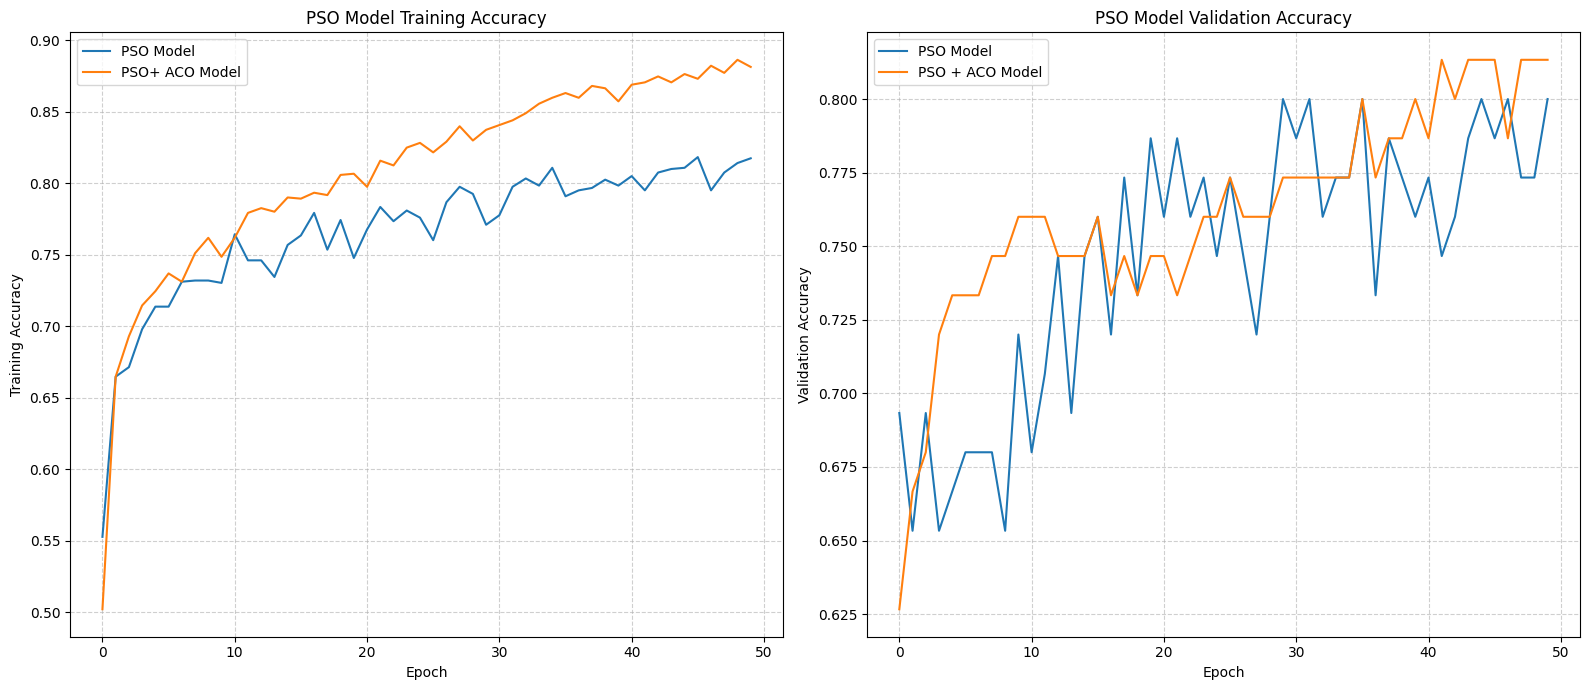

In [48]:
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.plot(history_pso.history['accuracy'], label='PSO Model', color='tab:blue')
plt.plot(history_aco_final.history['accuracy'], label='PSO+ ACO Model', color='tab:orange')
plt.title('PSO Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(history_pso.history['val_accuracy'], label='PSO Model', color='tab:blue')
plt.plot(history_aco_final.history['val_accuracy'], label='PSO + ACO Model', color='tab:orange')
plt.title('PSO Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

output_path = '/kaggle/working/pso_comparison_wide.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to {output_path}")

plt.show()